In [1]:
# Install FEniCS
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

--2024-04-14 00:22:10--  https://fem-on-colab.github.io/releases/fenics-install-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4161 (4.1K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   4.06K  --.-KB/s    in 0s      

2024-04-14 00:22:10 (38.7 MB/s) - ‘/tmp/fenics-install.sh’ saved [4161/4161]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/5182fde/releases/pybind11-inst

In [ ]:
from dolfin import *
from mshr import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

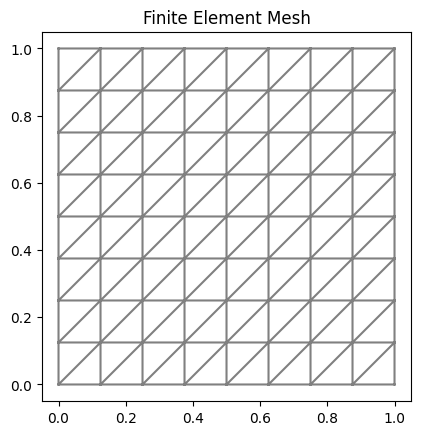

In [ ]:
# Create mesh
mesh = UnitSquareMesh(8, 8)
plot(mesh, title="Finite Element Mesh")
#plot(mesh)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from fenics import *
from mshr import *

#
circle1 = Circle(Point(-3, 0), 3)
circle2 = Circle(Point(3, 0), 3)
rectangle = Rectangle(Point(-3, -3), Point(3, 3))
domain = circle1 + rectangle + circle2

# Generate mesh
my_mesh = generate_mesh(domain, 20)

#
V = FunctionSpace(my_mesh, 'P', 1)

# boundary conditions
u1 = Expression('x[1]*x[1] + x[0]*x[0]', degree=4)
u2 = Constant(50.0)

def bottom(x, on_boundary):
    return near(x[1], -3) and on_boundary

def top(x, on_boundary):
    return near(x[1], 3) and on_boundary

def left(x, on_boundary):
    r = sqrt(x[0]*x[0]+x[1]*x[1])
    return on_boundary and r < 6*1.1

def right(x, on_boundary):
    r = sqrt(x[0]*x[0]+x[1]*x[1])
    return on_boundary and r < 6*1.1

bc1 = DirichletBC(V, u2, top)
bc2 = DirichletBC(V, u2, bottom)
bc3 = DirichletBC(V, u1, left)
bc4 = DirichletBC(V, u1, right)
bcs = [bc1, bc2, bc3, bc4]

#
u = TrialFunction(V)
v = TestFunction(V)

#
f = Expression('cos(x[0])*sin(x[1])', degree=4)

#
a = dot(grad(u), grad(v)) * dx
L = f * v * dx

#
uh = Function(V)
solve(a == L, uh, bcs)

# Plot
plt.figure()
plot(uh)
plt.show()

In [ ]:
import math
import numpy as np

import dolfin
from fenics import *
from mshr import *

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
n = 30
d = 1
mesh = generate_mesh(Rectangle(Point(-6, -6), Point(6, 6)), n)
plot(mesh)

V = FunctionSpace(mesh, 'P', 2)
print ("dim(Vh) = ", V.dim())

### 3. Setting problem parameters

In [ ]:
t_l = Constant(295.0)
t_r = Constant(375.0)

g_t = Constant(10.0)
g_b = Constant(0.0)

k0 = Constant(0.6)
f0 = Constant(0.0)

k1 = Constant(400.0)
f1 = Constant(100.0)

### 4.1 Define boundary labels

In [ ]:
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], -6.0)

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 6.0)

class Bottom(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], -6.0)

class Top(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 6.0)

# Initialize mesh function for boundary domains
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)
boundaries.set_all(0)
left = Left()
left.mark(boundaries, 1)
right = Right()
right.mark(boundaries, 2)
top = Top()
top.mark(boundaries, 3)
bottom = Bottom()
bottom.mark(boundaries, 4)

bcs = [
    DirichletBC(V, t_l, boundaries, 1),
    DirichletBC(V, t_r, boundaries, 2)
]

ds = Measure("ds", domain=mesh, subdomain_data=boundaries)

### 4.2 Define subdomains

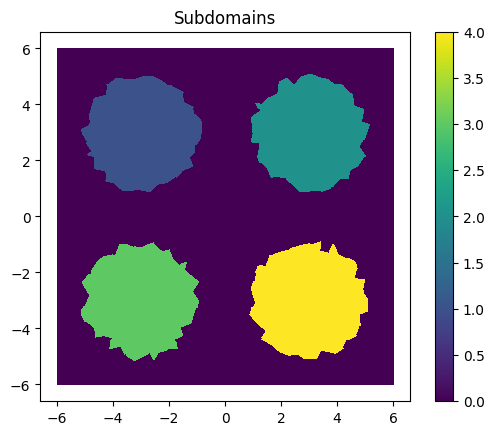

In [ ]:
class TopLeft(SubDomain):
    def inside(self, x, on_boundary):
        r = ((x[0]+3)**2 + (x[1]-3)**2) ** 0.5
        return r < 1.1 * 2

class TopRight(SubDomain):
    def inside(self, x, on_boundary):
        r = ((x[0]-3)**2 + (x[1]-3)**2) ** 0.5
        return r < 1.1 * 2

class BotLeft(SubDomain):
    def inside(self, x, on_boundary):
        r = ((x[0]+3)**2 + (x[1]+3)**2) ** 0.5
        return r < 1.1 * 2

class BotRight(SubDomain):
    def inside(self, x, on_boundary):
        r = ((x[0]-3)**2 + (x[1]+3)**2) ** 0.5
        return r < 1.1 * 2


# Initialize mesh function for interior domains
domains = MeshFunction("size_t", mesh, 2, mesh.domains())
domains.set_all(0)

topleft = TopLeft()
topleft.mark(domains, 1)
topright = TopRight()
topright.mark(domains, 2)
botleft = BotLeft()
botleft.mark(domains, 3)
botright = BotRight()
botright.mark(domains, 4)

p = plot(domains, title="Subdomains")
plt.colorbar(p)

dx = Measure('dx', domain=mesh, subdomain_data=domains)

### 4.2.1 subdomain thermal conductivity

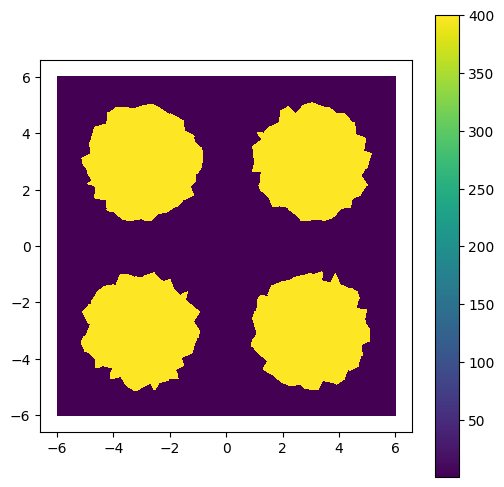

In [ ]:
V0 = FunctionSpace(mesh, 'DG', 0)
class rho(UserExpression):
    def __init__(self, markers, **kwargs):
        self.markers = markers
        super().__init__(**kwargs)
    def eval_cell(self, values, x, cell):
        if self.markers[cell.index] != 0:
            values[0] = k1
        else:
            values[0] = k0

thermal_conductivity = rho(domains, degree=1)

plt.figure(figsize=(6,6))
#plot(mesh, linewidth=0.5)
p = plot(project(thermal_conductivity, V0))
plt.colorbar(p)
plt.show()

### 4.2.2 subdomain thermal load

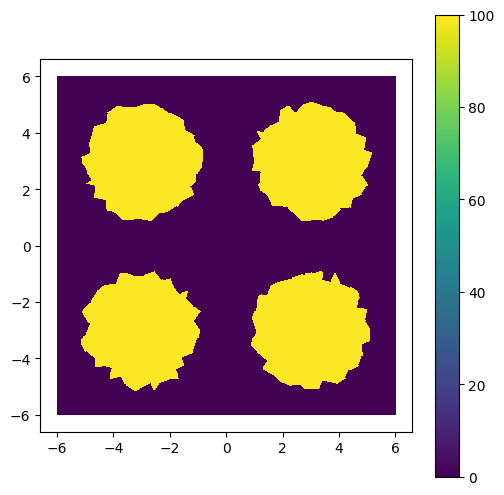

In [ ]:
V1 = FunctionSpace(mesh, 'DG', 0)
class rho2(UserExpression):
    def __init__(self, markers, **kwargs):
        self.markers = markers
        super().__init__(**kwargs)
    def eval_cell(self, values, x, cell):
        if self.markers[cell.index] != 0:
            values[0] = f1
        else:
            values[0] = f0

thermal_load = rho2(domains, degree=1)

plt.figure(figsize=(6,6))
#plot(mesh, linewidth=0.5)
p = plot(project(thermal_load, V1))
plt.colorbar(p)
plt.show()

### 5. Defining the variational problem

In [ ]:
u = TrialFunction(V)
v = TestFunction(V)
a = thermal_conductivity*inner(nabla_grad(u), nabla_grad(v))*dx
L = thermal_load*v*dx + g_t*v*ds(3) + g_b*v*ds(4)
uh = Function(V)

### 6. Solving the linear system

In [ ]:
uh = Function(V)
solve(a == L, uh, bcs=bcs)
#A, b = assemble_system(a, L, bcs=bcs)
#solve(A, uh.vector(), b, "cg")

p = plot(uh)
plt.colorbar(p)
plt.show()

In [ ]:
# Linear elasticity (for small deformation only)

 number of cells =  965


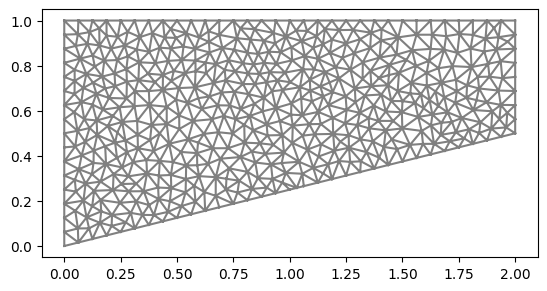

In [ ]:
# Create list of polygonal domain vertices
domain_vertices = [Point(0.0, 0.0),
                   Point(2.0, 0.5),
                   Point(2.0, 1.0),
                   Point(0.0, 1.0),
                   Point(0.0, 0.0)]
#
# Generate mesh and plot
domain = Polygon(domain_vertices)
#
mesh = generate_mesh(domain,20)
print (" number of cells = ",mesh.num_cells())
plot(mesh)

In [ ]:
V = FunctionSpace(mesh, 'P', 1)

# Boundary conditions
def left(x, on_boundary):
  return near(x[0], 0.0)


# Strain function
def epsilon(u):
    return sym(grad(u))

# Stress function
def sigma(u):
    return lambda_*div(u)*Identity(2) + 2*mu*epsilon(u)


In [ ]:
# --------------------
# Parameters
# --------------------

# Young's modulus and Poisson's ratio
E =  3e7      #210e9
nu = 0.3

# Lame's constants
lambda_ = E*nu/(1+nu)/(1-2*nu)
mu = E/2/(1+nu)

In [ ]:
# --------------------
# Function spaces
# --------------------
V = VectorFunctionSpace(mesh, "CG", 1)
u = TrialFunction(V)
v = TestFunction(V)

In [ ]:
# --------------------
# Boundary conditions
# --------------------
# 1. Define Dirichlet boundary condition
bc = DirichletBC(V, Constant((0.0,0.0)), left)

#
# 2. Definition of Neumann condition domain
#
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundaries.set_all(0)

#   AutoSubDomain: Create SubDomain subclass for given inside() function or lambda function
top = AutoSubDomain(lambda x: near(x[1], 1.))

top.mark(boundaries, 1)

# Define the integration on boundary
ds = Measure("ds", domain=mesh, subdomain_data=boundaries)

In [ ]:
# Load
# Weight density
rho_g = 0
#  Unform vertical loading due to self-weight
f = Constant((0.,0.))
# surface load
g = Constant((0.0, -20.0))

In [ ]:
# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
a = inner(sigma(u), epsilon(v))*dx
l = dot(f, v)*dx + dot(g, v)*ds(1)

In [ ]:
u = Function(V, name='Displacement')
# Compute solution
solve(a == l, u, bc,solver_parameters={"linear_solver": "cg","preconditioner":"hypre_amg"})

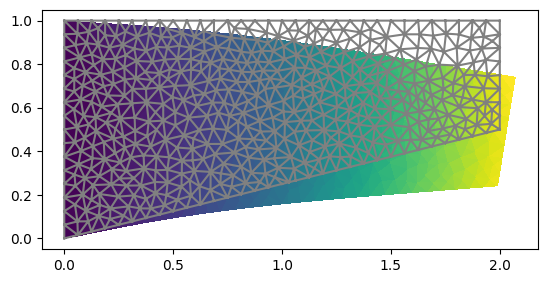

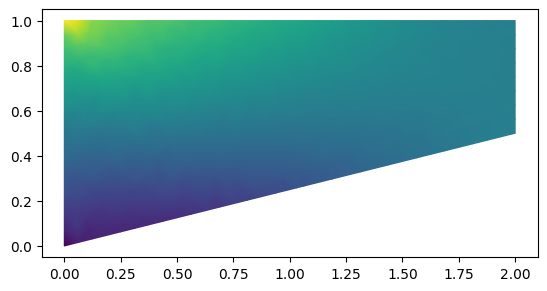

In [ ]:
# Plot Deformed Shape
plt.figure()
# scale factor
factor=10000
plot(factor*u, mode ="displacement")
plot(mesh)
# Plot stress σxx
plt.figure()
plot(sigma(u)[0,0], mode='color')
plt.show()


 number of cells =  1070


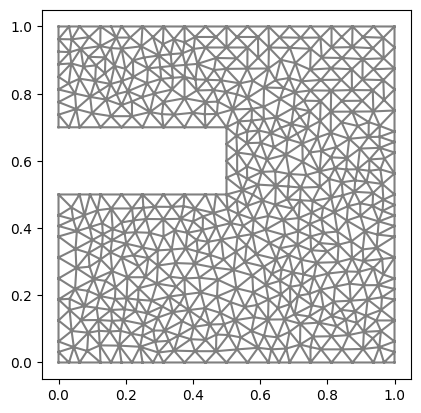

In [ ]:
# Create list of polygonal domain vertices
#
# Generate mesh and plot
domain = Rectangle (Point(0.0, 0.0), Point(1.0, 1.0)) - Rectangle ( Point(0.0, 0.5), Point(0.5, 0.7))
#
mesh = generate_mesh(domain,20)
print (" number of cells = ",mesh.num_cells())
plot(mesh)

In [ ]:
V = FunctionSpace(mesh, 'P', 1)

# Boundary conditions
def left(x, on_boundary):
  return near(x[0], 0.0)

def bottom(x, on_boundary):
  return near(x[1], 0.0)

# Strain function
def epsilon(u):
    return sym(grad(u))

# Stress function
def sigma(u):
    return lambda_*div(u)*Identity(2) + 2*mu*epsilon(u)

In [ ]:
# --------------------
# Parameters
# --------------------

# Young's modulus and Poisson's ratio
E =  210e6
nu = 0.3

# Lame's constants
lambda_ = E*nu/(1+nu)/(1-2*nu)
mu = E/2/(1+nu)

In [ ]:
# --------------------
# Function spaces
# --------------------
V = VectorFunctionSpace(mesh, "CG", 1)
u = TrialFunction(V)
v = TestFunction(V)

In [ ]:
# --------------------
# Boundary conditions
# --------------------
# 1. Define Dirichlet boundary condition
bc1 = DirichletBC(V, Constant((0.0,0.0)), left)
bc2 = DirichletBC(V, Constant((0.0,0.0)), bottom)
bc = [bc1,bc2]

#
# 2. Definition of Neumann condition domain
#
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundaries.set_all(0)

#   AutoSubDomain: Create SubDomain subclass for given inside() function or lambda function
right = AutoSubDomain(lambda x: near(x[0], 1.))

right.mark(boundaries, 1)

# Define the integration on boundary
ds = Measure("ds", domain=mesh, subdomain_data=boundaries)

In [ ]:
# Load
# Weight density
rho_g = 0
#  Unform vertical loading due to self-weight
f = Constant((0.,0.))
# surface load
g = Constant((1000.0, 0.0))

In [ ]:
# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
a = inner(sigma(u), epsilon(v))*dx
l = dot(f, v)*dx + dot(g, v)*ds(1)

In [ ]:
u = Function(V, name='Displacement')
# Compute solution
solve(a == l, u, bc,solver_parameters={"linear_solver": "cg","preconditioner":"hypre_amg"})

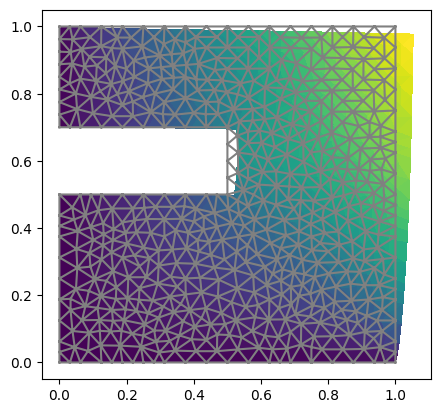

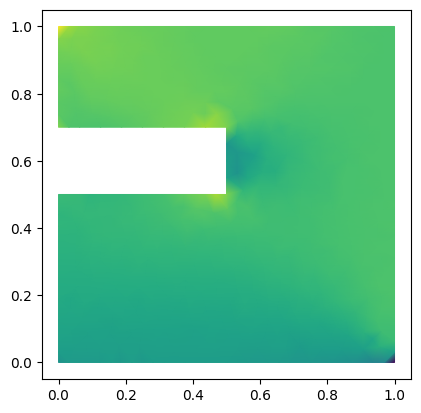

In [ ]:
# Plot Deformed Shape
plt.figure()
# scale factor
factor=10000
plot(factor*u, mode ="displacement")
plot(mesh)
# Plot stress σxx
plt.figure()
plot(sigma(u)[0,0], mode='color')
plt.show()


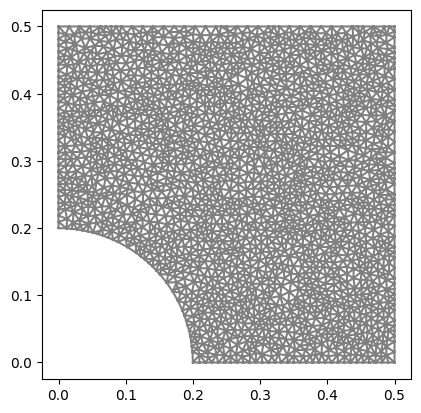

In [ ]:
L, R = 0.5, 0.2
N = 40 # mesh density

domain = Rectangle(Point(0.,0.), Point(L, L)) - Circle(Point(0., 0.), R)
mesh = generate_mesh(domain, N)
plot(mesh)

In [ ]:
# --------------------
# Functions and classes
# --------------------
def left(x, on_boundary):
    return (on_boundary and near(x[0], 0.0))

def bottom(x, on_boundary):
    return (on_boundary and near(x[1], 0.0))

# Strain function
def epsilon(u):
    return sym(grad(u))

# Stress function
def sigma(u):
    return lambda_*div(u)*Identity(2) + 2*mu*epsilon(u)

In [ ]:
# --------------------
# Parameters
# --------------------

# Young's modulus and Poisson's ratio
E =  200e6      #210e9
nu = 0.3

# Lame's constants
lambda_ = E*nu/(1+nu)/(1-2*nu)
mu = E/2/(1+nu)

In [ ]:
# --------------------
# Function spaces
# --------------------
V = VectorFunctionSpace(mesh, "CG", 1)
u = TrialFunction(V)
v = TestFunction(V)

In [ ]:
# --------------------
# Boundary conditions
# --------------------
# 1. Define Dirichlet boundary condition
bc1 = DirichletBC(V.sub(0), Constant((0.0)), left)
bc2 = DirichletBC(V.sub(1), Constant((0.0)), bottom)
bc = [bc1, bc2]
#
# 2. Definition of Neumann condition domain
#
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundaries.set_all(0)

#   AutoSubDomain: Create SubDomain subclass for given inside() function or lambda function
in_cir = AutoSubDomain(lambda x: x[1]*x[1] + x[0]*x[0] < R*R*1.1)

in_cir.mark(boundaries, 1)

# Define the integration on boundary
ds = Measure("ds", domain=mesh, subdomain_data=boundaries)

In [ ]:
# Load
# Weight density
rho_g = 0
#  Unform vertical loading due to self-weight
f = Constant((0.,-rho_g))
# surface load
g = Expression ( ( '100*x[0]/R', '100*x[1]/R' ), degree = 10, R=0.2 )

In [ ]:
# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
a = inner(sigma(u), epsilon(v))*dx
l = dot(f, v)*dx + dot(g, v)*ds(1)

In [ ]:
u = Function(V, name='Displacement')
# Compute solution
solve(a == l, u, bc,solver_parameters={"linear_solver": "cg","preconditioner":"hypre_amg"})

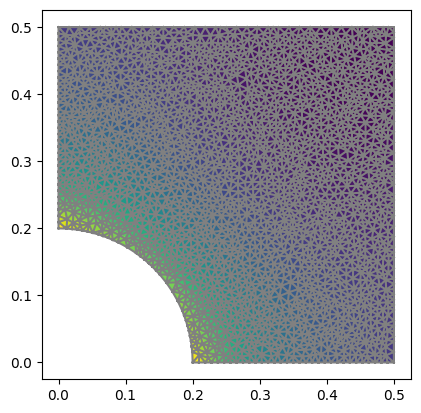

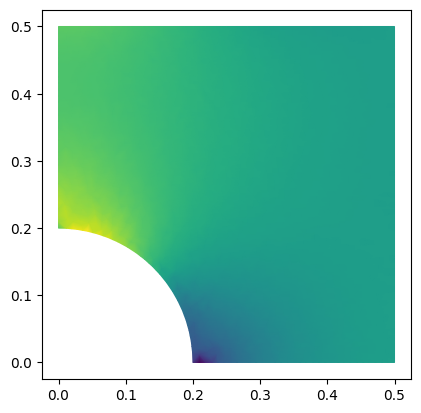

Deflection : -4.56201e-08


In [ ]:
# Plot Deformed Shape
plt.figure()
# scale factor
factor=10000
plot(factor*u, mode ="displacement")
plot(mesh)
# Plot stress σxx
plt.figure()
plot(sigma(u)[0,0], mode='color')
plt.show()

# Beam deflection calculation
w_max = -u(L,R)[1]

print("Deflection : %g" % w_max)

INFO:FFC:  Generating code for 1 dofmap(s)
INFO:FFC:  Generating code for 0 coordinate_mapping(s)
INFO:FFC:  Generating code for integrals
INFO:FFC:  Generating code for forms
INFO:FFC:  
INFO:FFC:Compiler stage 4 finished in 57.2607 seconds.

INFO:FFC:Compiler stage 4.1 finished in 3.57628e-06 seconds.

INFO:FFC:Compiler stage 5: Formatting code
INFO:FFC:---------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 5 finished in 0.111016 seconds.

INFO:FFC:FFC finished in 57.4444 seconds.


Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling coordinate_mapping ffc_coordinate_mapping_3720490578293ae8ad5feabedc46584f48fda4c4

INFO:FFC:Compiler stage 1: Analyzing coordinate_mapping(s)
INFO:FFC:-------------------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00415111 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 0 elements
INFO:FFC:  Computing representation of 0 dofmaps
INFO:FFC:  Computing representation of 1 coordinate mappings
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0110593 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:--------------------------------------------------------
INFO

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_349f8de442820dc589c5dd77f7c80ddd91c603a1

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 0
INFO:FFC:  quadrature_degree: 0
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0442739 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:---------------------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_82a53c44eef9856bb7c50f989a687f5eca40ef43

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.026195 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:----------------------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_899f792bca9deb3c3f12f5cb62d42f0545d411ea

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00303292 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0166552 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_79dd4099c4e669212673d783637297ee756e6a33

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00900197 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0256052 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling coordinate_mapping ffc_coordinate_mapping_66170f427fb7c9d9caadb39d728b0be317507df5

INFO:FFC:Compiler stage 1: Analyzing coordinate_mapping(s)
INFO:FFC:-------------------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00483847 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 0 elements
INFO:FFC:  Computing representation of 0 dofmaps
INFO:FFC:  Computing representation of 1 coordinate mappings
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0117698 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:--------------------------------------------------------
INFO

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_c214615260870d7287aa95a5fdae77e942a5e8ce

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[Displacement]'
  Unique elements:           'Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0264792 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:--------------------------------

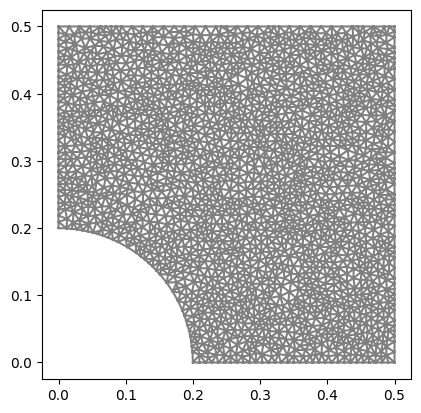

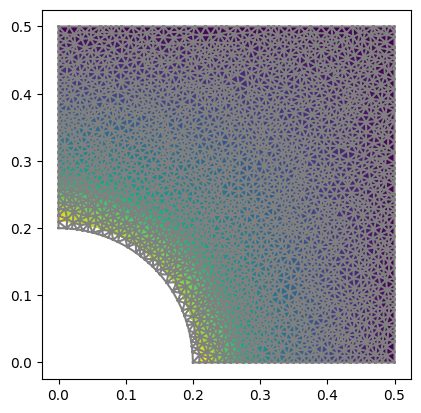

In [2]:
from dolfin import *
import matplotlib.pyplot as plt
from mshr import *
%matplotlib inline

L, R = 0.5, 0.2
N = 40 # mesh density

domain = Rectangle(Point(0.,0.), Point(L, L)) - Circle(Point(0., 0.), R)
mesh = generate_mesh(domain, N)
plot(mesh)

# --------------------
# Functions and classes
# --------------------
def left(x, on_boundary):
  return (on_boundary and near(x[0], 0.0))

def bottom(x, on_boundary):
  return (on_boundary and near(x[1], 0.0))

def top(x, on_boundary):                       #<--------------------------------
  return (on_boundary and near(x[1], 0.5))     #<--------------------------------

def right(x, on_boundary):                     #<--------------------------------
  return (on_boundary and near(x[0], 0.5))     #<--------------------------------

# Strain function
def epsilon(u):
  return sym(grad(u))

# Stress function
def sigma(u):
  return lambda_*div(u)*Identity(2) + 2*mu*epsilon(u)

# --------------------
# Parameters
# --------------------

# Young's modulus and Poisson's ratio
E =  200e6      #210e9
nu = 0.3

# Lame's constants
lambda_ = E*nu/(1+nu)/(1-2*nu)
mu = E/2/(1+nu)

# --------------------
# Function spaces
# --------------------
V = VectorFunctionSpace(mesh, "CG", 1)
u = TrialFunction(V)
v = TestFunction(V)

# --------------------
# Boundary conditions
# --------------------
# 1. Define Dirichlet boundary condition
bc1 = DirichletBC(V.sub(0), Constant((0.0)), left)
bc2 = DirichletBC(V.sub(1), Constant((0.0)), bottom)
bc3 = DirichletBC(V, Constant((0.0, 0.0)), top)                     #<--------------------------------
bc4 = DirichletBC(V, Constant((0.0, 0.0)), right)                   #<--------------------------------
bc = [bc1, bc2, bc3, bc4]                                           #<--------------------------------
#
# 2. Definition of Neumann condition domain
#
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundaries.set_all(0)

#   AutoSubDomain: Create SubDomain subclass for given inside() function or lambda function
in_cir = AutoSubDomain(lambda x: x[1]*x[1] + x[0]*x[0] < R*R*1.1)

in_cir.mark(boundaries, 1)

# Define the integration on boundary
ds = Measure("ds", domain=mesh, subdomain_data=boundaries)

# Load
# Weight density
rho_g = 0
#  Unform vertical loading due to self-weight
f = Constant((0.,-rho_g))
# surface load
g = Expression ( ( '100*x[0]/R', '100*x[1]/R' ), degree = 10, R=0.2 )

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
a = inner(sigma(u), epsilon(v))*dx
l = dot(f, v)*dx + dot(g, v)*ds(1)

u = Function(V, name='Displacement')
# Compute solution
solve(a == l, u, bc,solver_parameters={"linear_solver": "cg","preconditioner":"hypre_amg"})

# Plot Deformed Shape
plt.figure()
# scale factor
factor=100000
plot(factor*u, mode ="displacement")
plot(mesh)